# Atividade aula 3

 > Regressão Logística - Student Exam Performance Prediction

 * Aluno: Pedro Henrique de Amaral Lira

## Importando Bibliotecas

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score
)
import matplotlib.pyplot as plt
import joblib
import os

## Importando dataset

In [13]:
df = pd.read_csv("student_exam_data_new.csv")
print("dataset carregado:", df.shape)
print(df.head())

dataset carregado: (500, 3)
   Study Hours  Previous Exam Score  Pass/Fail
0     4.370861            81.889703          0
1     9.556429            72.165782          1
2     7.587945            58.571657          0
3     6.387926            88.827701          1
4     2.404168            81.083870          0


## Limpando dados

In [15]:
df = df.dropna(how="all")

na_counts = df.isna().sum()
print("\nMissing values:\n", na_counts)

if na_counts.sum() > 0:
    df = df.dropna()

print("Após limpeza:", df.shape)


Missing values:
 Study Hours            0
Previous Exam Score    0
Pass/Fail              0
dtype: int64
Após limpeza: (500, 3)


## Identificação de colunas

In [16]:
possible_targets = [c for c in df.columns if c.lower() in ("passed","pass","result","status","exam_status","label","target","pass/fail")]
target_col = None

if possible_targets:
    target_col = possible_targets[0]
else:
    for c in df.columns:
        if df[c].nunique() == 2:
            target_col = c
            break

if target_col is None:
    raise ValueError("Nenhuma coluna binaria identificada")

print("Using target:", target_col)
df[target_col] = df[target_col].astype(int)

print(df[target_col].value_counts())

Using target: Pass/Fail
Pass/Fail
0    316
1    184
Name: count, dtype: int64


## Preparação de features

In [18]:
feature_cols = [c for c in df.columns if c != target_col]

numeric_cols = [c for c in feature_cols if df[c].dtype.kind in "biufc"]
categorical_cols = [c for c in feature_cols if c not in numeric_cols]

print("Colunas numéricas:", numeric_cols)
print("Colunas Categóricas:", categorical_cols)

X_num = df[numeric_cols]

if categorical_cols:
    ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
    X_cat_encoded = pd.DataFrame(
        ohe.fit_transform(df[categorical_cols]),
        columns=ohe.get_feature_names_out(categorical_cols)
    )
else:
    X_cat_encoded = pd.DataFrame()

# Combinar features
X = pd.concat([X_num.reset_index(drop=True), X_cat_encoded.reset_index(drop=True)], axis=1)
y = df[target_col].values.reshape(-1, 1)

print("Final feature matrix:", X.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Colunas numéricas: ['Study Hours', 'Previous Exam Score']
Colunas Categóricas: []
Final feature matrix: (500, 2)


## Divisão treino/teste

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train / test:", X_train.shape, X_test.shape)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

Train / test: (400, 2) (100, 2)


## Regressão Logística

In [21]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

model = LogisticRegression(X_train_t.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)


## Loop de treino

In [22]:
loss_history = []
epochs = 300

for epoch in range(epochs):
    model.train()
    epoch_losses = []

    for xb, yb in train_loader:
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    loss_history.append(np.mean(epoch_losses))

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss_history[-1]:.4f}")

Epoch 50/300 - Loss: 0.2849
Epoch 100/300 - Loss: 0.2739
Epoch 150/300 - Loss: 0.2837
Epoch 200/300 - Loss: 0.2748
Epoch 250/300 - Loss: 0.2748
Epoch 300/300 - Loss: 0.2816


## Avaliação

In [23]:
model.eval()
with torch.no_grad():
    probs = model(X_test_t).numpy().reshape(-1)
    preds = (probs >= 0.5).astype(int)
    y_true = y_test.reshape(-1)

acc = accuracy_score(y_true, preds)
prec = precision_score(y_true, preds)
rec = recall_score(y_true, preds)
f1 = f1_score(y_true, preds)
cm = confusion_matrix(y_true, preds)
auc = roc_auc_score(y_true, probs)

print("\n===== Test Results =====")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1:", f1)
print("AUC:", auc)
print("Confusion Matrix:\n", cm)


===== Test Results =====
Accuracy: 0.88
Precision: 0.8378378378378378
Recall: 0.8378378378378378
F1: 0.8378378378378378
AUC: 0.9596739596739596
Confusion Matrix:
 [[57  6]
 [ 6 31]]


## Plot de treino

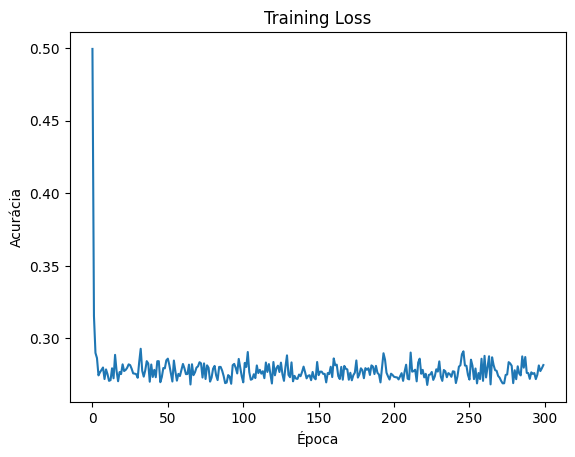

In [26]:
plt.plot(loss_history)
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Training Loss")
plt.show()

## Avaliação

### Parametro pós treinamento

In [27]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[2.9715, 2.4901]])),
             ('linear.bias', tensor([-1.5819]))])

### Salvando parametros treinados

In [30]:
os.makedirs("/mnt/data/model_artifacts", exist_ok=True)

torch.save(model.state_dict(), "/mnt/data/model_artifacts/logreg_model.pth")
joblib.dump(scaler, "/mnt/data/model_artifacts/scaler.pkl")

if categorical_cols:
    joblib.dump(ohe, "/mnt/data/model_artifacts/ohe.pkl")

print("Model and preprocessors saved in /mnt/data/model_artifacts/")

Model and preprocessors saved in /mnt/data/model_artifacts/
